###### TODO:

1.  Take MBDNL as the reference to quantify the error ( user relative error )

2.  Check for Cu and Alkaline Earth metals

3.  Find formal charges by beggar's analysis in MBDNL optimised geometry

4.  Consider absolute electronegetiy of each elements present also as a fetaure function ( for the mettalic things )

5.  Polarisibility 



In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [199]:
copper = pd.read_csv('d3/Cu.csv')
copper_mbd = pd.read_csv('mbd/Cu_mbdnl.csv')

LiHd = pd.read_csv('d3/LiH.csv')
LiHmbd = pd.read_csv('mbd/LiH.csv')

In [200]:
copper_mbd.head()

,cell_length,energy,E-dispersion
0,2.777431,14.479846,-3.56830
1,2.977431,-3.002095,-3.18611
2,3.177431,-11.667733,-2.84942
3,3.377431,-15.462080,-2.55013
4,3.577431,-16.579741,-2.27569


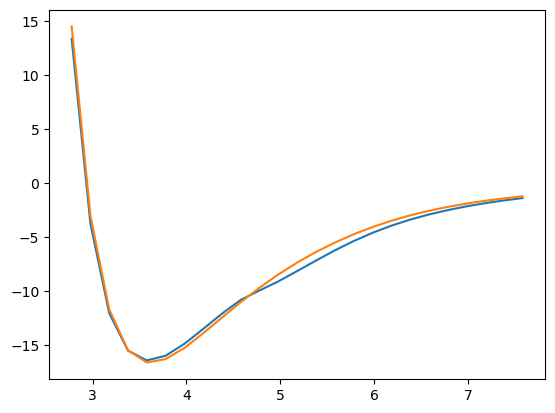

In [201]:
# plt.plot(cuppor['cell_length'], cuppor['energy'], 'o')
plt.plot(copper['cell_length'], copper['energy'])

# plt.plot(copper_mbd['cell_length'], copper_mbd['energy'], 'o')
plt.plot(copper_mbd['cell_length'], copper_mbd['energy'])

plt.show()

In [202]:
offset = copper_mbd['energy'][6] - copper['energy'][6]

diffs = copper_mbd['energy'] - copper['energy']

diffs = diffs - offset
cols = ['distance','energy']

cu = pd.DataFrame({
    'distance': copper['cell_length'].reset_index(drop=True),
    'energy': diffs.reset_index(drop=True)
})


max(cu['energy'])
cu

,distance,energy
0,2.777431,1.523881
1,2.977431,1.123815
2,3.177431,0.740245
3,3.377431,0.402150
4,3.577431,0.191466
5,3.777431,0.072015
6,3.977431,0.000000
7,4.177431,-0.016271
8,4.377431,0.022903
9,4.577431,0.172221


In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compare_energy_data(data1, data2, offset_ref_index=(0, 6)):
    """
    Compare energy differences between two datasets with different cell lengths.

    Parameters:
        data1 (pd.DataFrame): First dataset with 'cell_length' and 'energy' columns.
        data2 (pd.DataFrame): Second dataset with 'cell_length' and 'energy' columns.
        offset_ref_index (tuple): A tuple specifying indices for offset calculation 
                                  (index for data1['energy'], index for data2['energy']).
    
    Returns:
        pd.DataFrame: DataFrame with energy differences and interpolated values.
    """
    # Calculate offset based on specified reference indices
    offset = data1['energy'][offset_ref_index[0]] - data2['energy'][offset_ref_index[1]]
    
    # Interpolate data2's energy values at data1's cell_length points
    data2_interp = np.interp(data1['cell_length'], data2['cell_length'], data2['energy'])
    
    # Calculate the difference in energy values
    energy_diff =  data2_interp - data1['energy'] - offset
    
    # Add the difference to the DataFrame for visualization
    result = data1.copy()
    result['energy_diff'] = energy_diff
    result['data2_interp'] = data2_interp

    # Plot the original data
    plt.figure(figsize=(10, 6))
    plt.plot(data1['cell_length'], data1['energy'], label='Data 1 (Reference)', marker='o')
    plt.plot(data2['cell_length'], data2['energy'], label='Data 2 (Original)', marker='x')
    plt.plot(data1['cell_length'], energy_diff, label='Energy Difference', linestyle='--')

    # Add labels and legend
    plt.xlabel('Cell Length')
    plt.ylabel('Energy')
    plt.title('Comparison of Energy vs Cell Length')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()

    return result, data1


In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def optimize_polynomial_degree(data1, energy_diff, max_degree=10):
    """
    Optimize the polynomial degree by using cross-validation and selecting the best degree based on MSE.

    Parameters:
        data1 (pd.DataFrame): The dataset with 'cell_length' column.
        energy_diff (pd.Series): The energy difference data.
        max_degree (int): The maximum degree to consider for polynomial fitting. Default is 10.
    
    Returns:
        tuple: (best_degree, best_mse) - The optimal polynomial degree and the corresponding MSE.
    """
    best_degree = None
    best_mse = float('inf')  # Start with an infinitely large MSE to minimize it
    
    # Prepare the data
    X = data1['cell_length'].values.reshape(-1, 1)
    y = energy_diff.values

    # Remove rows where y has NaN values
    valid_indices = ~np.isnan(y)
    X = X[valid_indices]
    y = y[valid_indices]

    print(y)
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    for degree in range(1, max_degree + 1):
        # Generate polynomial features for the current degree
        poly_features = PolynomialFeatures(degree=degree)
        X_train_poly = poly_features.fit_transform(X_train)
        X_val_poly = poly_features.transform(X_val)
        
        # Fit the model
        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        
        # Make predictions on the validation set
        y_pred = model.predict(X_val_poly)
        
        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_val, y_pred)
        
        # If this MSE is better, update the best degree and MSE
        if mse < best_mse:
            best_mse = mse
            best_degree = degree
    
    print(f"Optimal Polynomial Degree: {best_degree} with MSE: {best_mse:.4f}")
    return best_degree, best_mse

def find_polynomial_maximum_with_optimal_degree(data1, energy_diff, max_degree=10):
    """
    Fit a polynomial regression to the data with an optimized degree and find the maximum value of the polynomial curve.

    Parameters:
        data1 (pd.DataFrame): The dataset with 'cell_length' column.
        energy_diff (pd.Series): The energy difference data.
        max_degree (int): The maximum degree to consider for polynomial fitting. Default is 10.
    
    Returns:
        tuple: (max_cell_length, max_energy_diff) - The cell length and energy difference at the maximum.
    """
    # Remove rows with NaN values from energy_diff and align with data1
    valid_indices = energy_diff.dropna().index
    data1 = data1.loc[valid_indices].reset_index(drop=True)
    energy_diff = energy_diff.dropna().reset_index(drop=True)

    # Find the optimal polynomial degree
    # optimal_degree, _ = optimize_polynomial_degree(data1, energy_diff, max_degree=max_degree)
    
    optimal_degree = max_degree

    # Prepare the polynomial features for the optimal degree
    poly_features = PolynomialFeatures(degree=optimal_degree)
    X_poly = poly_features.fit_transform(data1['cell_length'].values.reshape(-1, 1))
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_poly, energy_diff)
    
    # Generate finer cell length values for extrapolation
    fine_cell_lengths = np.linspace(min(data1['cell_length']), max(data1['cell_length']), 500)
    fine_cell_lengths_poly = poly_features.transform(fine_cell_lengths.reshape(-1, 1))
    energy_diff_fine = model.predict(fine_cell_lengths_poly)
    
    # Calculate the first derivative (slope) of the fitted polynomial
    poly_coeffs = model.coef_[1:]  # Skip the first coefficient as it corresponds to the constant term
    first_derivative_coeffs = np.polyder(poly_coeffs)
    
    # Find the root of the first derivative (where slope = 0)
    critical_points = np.roots(first_derivative_coeffs)
    
    # We are interested in real roots that fall within the domain of the data
    critical_points_real = [point.real for point in critical_points if point.imag == 0 and min(data1['cell_length']) <= point.real <= max(data1['cell_length'])]
    
    # Evaluate the second derivative to check for maxima
    second_derivative_coeffs = np.polyder(first_derivative_coeffs)
    
    max_cell_length = None
    max_energy_diff = None
    
    for point in critical_points_real:
        # Evaluate the second derivative at each critical point to check for maximum (second derivative < 0)
        second_derivative_value = np.polyval(second_derivative_coeffs, point)
        if second_derivative_value < 0:  # This means it's a maximum
            max_cell_length = point
            max_energy_diff = np.polyval(poly_coeffs, point)
            break
    
    # Plot the original data and polynomial fit
    plt.figure(figsize=(10, 6))
    plt.plot(data1['cell_length'], energy_diff, label='Energy Difference', linestyle='--', marker='o')
    plt.plot(fine_cell_lengths, energy_diff_fine, label=f'Polynomial Fit (Degree {optimal_degree})', linestyle='--')
    # plt.scatter(max_cell_length, max_energy_diff, color='red', label=f'Maximum at {max_cell_length:.3f}')
    
    # Add labels and legend
    plt.xlabel('Cell Length')
    plt.ylabel('Energy Difference')
    plt.title(f'Energy Difference and Polynomial Regression (Optimal Degree {optimal_degree})')
    plt.legend()
    plt.grid()
    
    # Show the plot
    plt.show()

    return max_cell_length, max_energy_diff

# Example usage:
# Assuming `data1` is your dataframe with 'cell_length' and `energy_diff` is your computed energy difference
# max_cell, max_energy = find_polynomial_maximum_with_optimal_degree(data1, energy_diff)


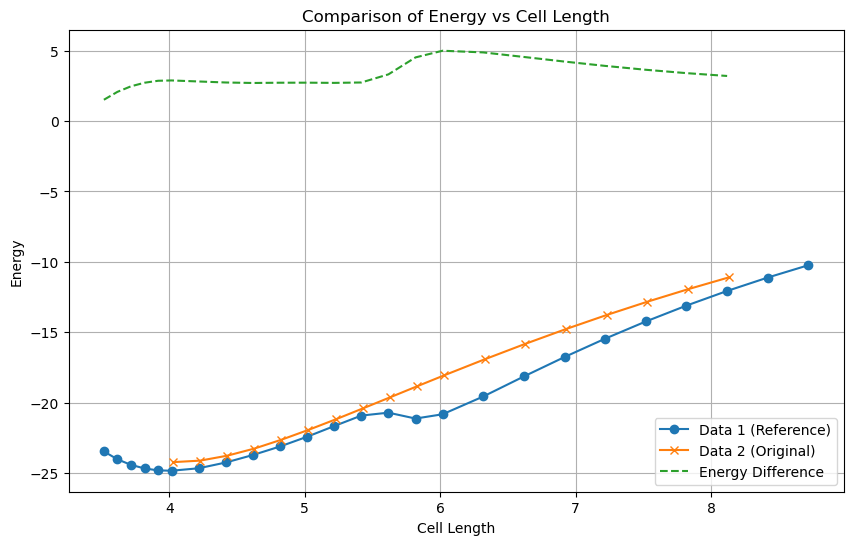

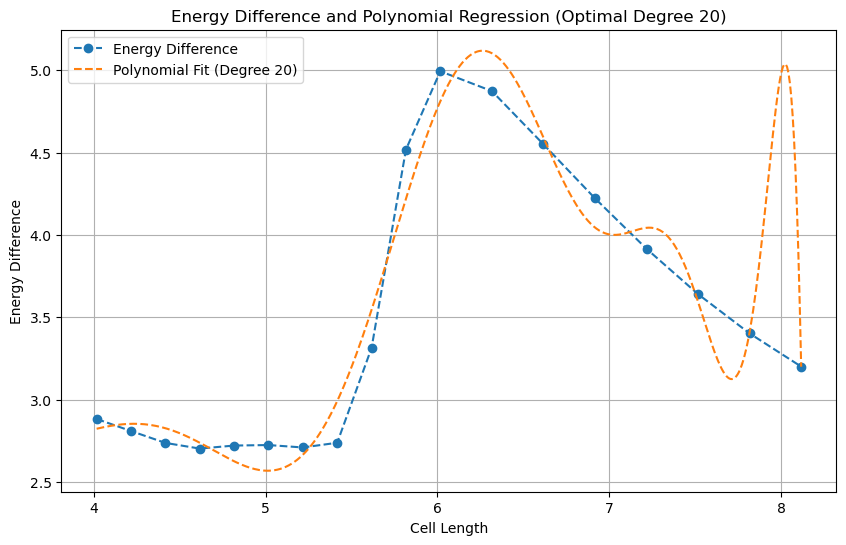

(None, None)

In [312]:

res , data1 = compare_energy_data(LiHd,LiHmbd,offset_ref_index=(0,6))
# pol_degree,_ = optimize_polynomial_degree(data1,res['energy_diff'])

find_polynomial_maximum_with_optimal_degree(data1.iloc[5:,:],res['energy_diff'][5:],max_degree=20)


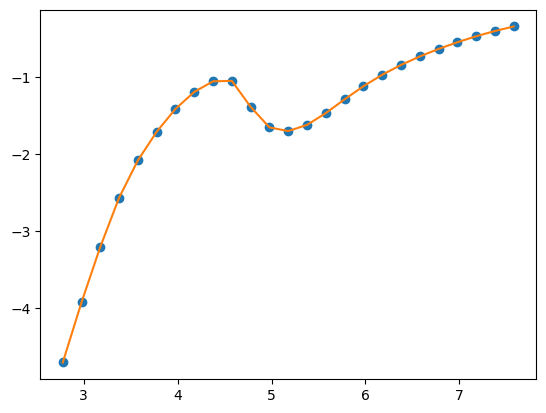

In [205]:
plt.plot(copper['cell_length'], copper['E-dispersion'], 'o')
plt.plot(copper['cell_length'], copper['E-dispersion'])
plt.show()

In [206]:
import itertools
import numpy as np

def generate_combinations(params, param_names, operators):
    results = []

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(params) + 1):
        for subset_indices in itertools.permutations(range(len(params)), r):  # Permutations of parameter indices
            subset = [params[i] for i in subset_indices]
            subset_names = [param_names[i] for i in subset_indices]

            if len(subset) == 1:
                expr_str = subset_names[0]
                expr_val = subset[0]
                results.append((expr_str, expr_val))
            else:
                for ops in itertools.product(operators, repeat=len(subset) - 1):
                    # Construct the expression as a string
                    expr_str = subset_names[0]
                    expr_val = subset[0]

                    for i in range(len(ops)):
                        expr_str += f" {ops[i]} {subset_names[i + 1]}"
                        if ops[i] == '*':
                            expr_val = expr_val * subset[i + 1]
                        elif ops[i] == '/':
                            expr_val = expr_val / subset[i + 1]
                    results.append((expr_str, expr_val))

    return results


In [207]:
a = np.array([1, 2, 3, 4])
b = np.array([5, 6, 7, 8])
c = np.array([9, 10, 11, 12])
d = np.array([13, 14, 15, 16])
e = np.array([13, 14, 15, 16])
parameters = [a, b, c, d,e]
param_names = ['a', 'b', 'c', 'd','e']

# Define mathematical operators
operators = ['*', '/',]

# Generate and evaluate all expressions
all_expressions = generate_combinations(parameters, param_names, operators)

df = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

df.shape

(3165, 2)

In [208]:

values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)

In [209]:
values.head()

correlation = values.corr()

correlation = correlation[correlation['a'] == 1]
correlation.tail()

,a,b,c,d,e,a * b,a / b,a * c,a / c,a * d,...,e * d / c / b * a,e * d / c / b / a,e / d * c * b * a,e / d * c * b / a,e / d * c / b * a,e / d * c / b / a,e / d / c * b * a,e / d / c * b / a,e / d / c / b * a,e / d / c / b / a
e * b / d,1.0,1.0,1.0,1.0,1.0,0.995098,0.990366,0.997642,0.996347,0.998619,...,0.996329,-0.9207,0.988243,-0.909025,0.999208,-0.924165,0.999353,-0.932423,0.958726,-0.912158
e * c / d,1.0,1.0,1.0,1.0,1.0,0.995098,0.990366,0.997642,0.996347,0.998619,...,0.996329,-0.9207,0.988243,-0.909025,0.999208,-0.924165,0.999353,-0.932423,0.958726,-0.912158
e / d * a,1.0,1.0,1.0,1.0,1.0,0.995098,0.990366,0.997642,0.996347,0.998619,...,0.996329,-0.9207,0.988243,-0.909025,0.999208,-0.924165,0.999353,-0.932423,0.958726,-0.912158
e / d * b,1.0,1.0,1.0,1.0,1.0,0.995098,0.990366,0.997642,0.996347,0.998619,...,0.996329,-0.9207,0.988243,-0.909025,0.999208,-0.924165,0.999353,-0.932423,0.958726,-0.912158
e / d * c,1.0,1.0,1.0,1.0,1.0,0.995098,0.990366,0.997642,0.996347,0.998619,...,0.996329,-0.9207,0.988243,-0.909025,0.999208,-0.924165,0.999353,-0.932423,0.958726,-0.912158
